In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from scipy import stats
from sklearn import svm


import os

In [1]:
import sys
import sklearn

In [5]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

In [7]:
import pandas as pd

path = '/content/drive/MyDrive/forest+fires/'
dfmain = pd.read_csv('C:/Users/Harsakshi Bhanushali/Downloads/forest+fires/forestfires.csv', header=0)
print(dfmain.shape)
dfmain.head(2)

(517, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0


In [8]:
dfmain['fire_scale'] = dfmain['area'].apply(lambda x: 'no_fire' if (x==0) else
                                                      'small_fire' if ((x>0)&(x<2))else
                                                      'large_fire'
                                           )
print(dfmain.shape)
dfmain.head(2)

(517, 14)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,fire_scale
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,no_fire
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,no_fire


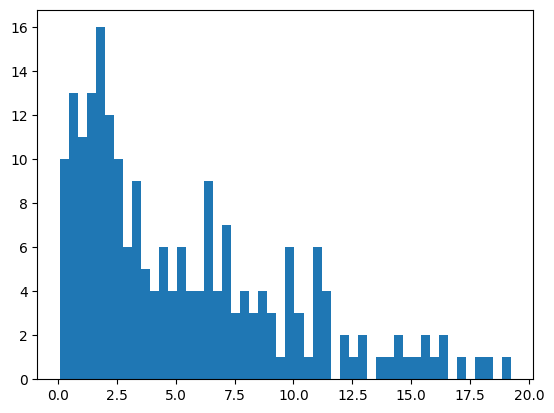

In [9]:
plt.hist(dfmain[(dfmain['area']>0)&(dfmain['area']<20)].area, bins=50)

plt.show()

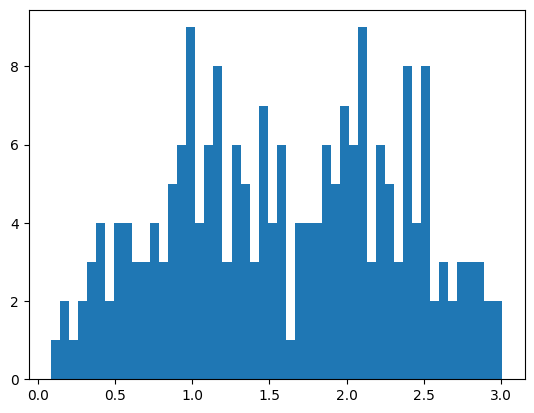

In [10]:
plt.hist(np.log(dfmain[(dfmain['area']>0)&(dfmain['area']<20)].area + 1), bins=50)

plt.show()

<BarContainer object of 12 artists>

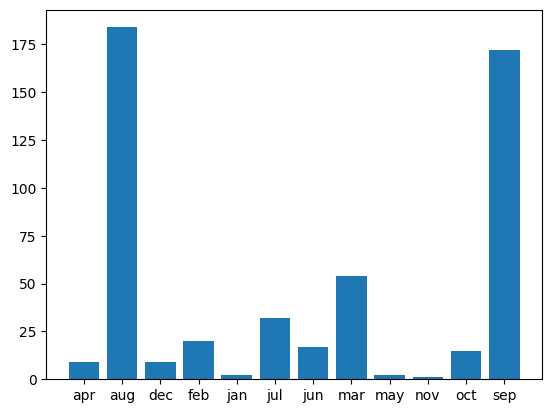

In [11]:
t = dfmain.groupby(['month'])['month'].count()
plt.bar(t.index, t)

In [12]:
dfmain.groupby(['month', 'fire_scale'])['fire_scale'].count()

month  fire_scale
apr    large_fire     4
       no_fire        5
aug    large_fire    71
       no_fire       85
       small_fire    28
dec    large_fire     9
feb    large_fire     9
       no_fire       10
       small_fire     1
jan    no_fire        2
jul    large_fire    12
       no_fire       14
       small_fire     6
jun    large_fire     5
       no_fire        9
       small_fire     3
mar    large_fire    16
       no_fire       35
       small_fire     3
may    large_fire     1
       no_fire        1
nov    no_fire        1
oct    large_fire     5
       no_fire       10
sep    large_fire    76
       no_fire       75
       small_fire    21
Name: fire_scale, dtype: int64

<BarContainer object of 7 artists>

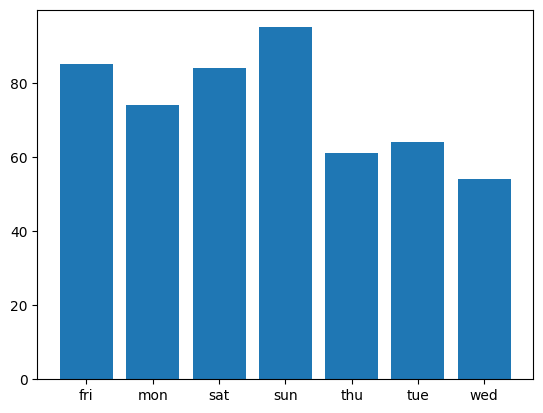

In [13]:
t = dfmain.groupby(['day'])['day'].count()
plt.bar(t.index, t)

In [14]:
#d = dfmain.copy()
d = dfmain[dfmain['area']>0].copy()

In [15]:
print(d.shape)
for m in d['month'].unique():
    if((m!='aug')&(m!='sep')):
        temp = d[d['month']==m].sample(300, replace=True)
        d = pd.concat([d, temp], axis=0)

print(d.shape)



(270, 14)
(2670, 14)


<BarContainer object of 10 artists>

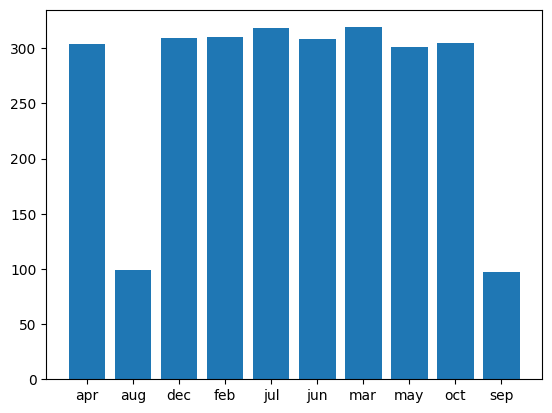

In [16]:
# plot
t = d.groupby(['month'])['month'].count()
plt.bar(t.index, t)

Regression/Prediction

In [17]:
X = d.drop(['area', 'fire_scale'], axis=1)
y = d['area']

In [18]:
X = pd.get_dummies(X, ['month', 'day'])
X.head(2)

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_apr,month_aug,month_dec,month_feb,month_jul,month_jun,month_mar,month_may,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
138,9,9,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
139,1,4,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False


In [19]:
x_cols_for_scaling = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

Split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, np.log(y+1), shuffle=True)
print(x_train.shape, x_test.shape)

(2002, 27) (668, 27)


Split for scaling

In [21]:
x_train_orig = x_train.loc[:, x_cols_for_scaling]
x_train_cat = x_train.drop(x_cols_for_scaling, axis=1)

x_test_orig = x_test.loc[:, x_train_orig.columns]
x_test_cat = x_test.loc[:, x_train_cat.columns]

StandardScaler

In [22]:
scl=preprocessing.StandardScaler()
scl.fit(x_train_orig)

x_train_orig = scl.transform(x_train_orig)
x_test_orig = scl.transform(x_test_orig)

# Combine
x_train = np.concatenate([x_train_orig, np.array(x_train_cat)], axis=1)
x_test = np.concatenate([x_test_orig, np.array(x_test_cat)], axis=1)

print(x_train.shape, x_test.shape)

(2002, 27) (668, 27)


mse:  0.1367
mae:  0.1042
r2:  0.8787


Text(0, 0.5, 'y_pred')

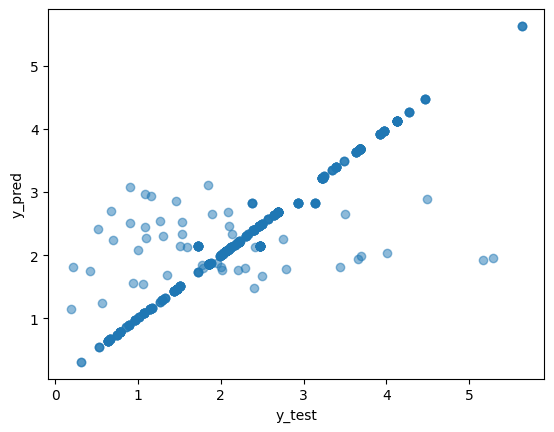

In [23]:
from sklearn.ensemble import BaggingRegressor
reg = BaggingRegressor()
reg.fit(x_train, y_train)

# Predict
y_pred = reg.predict(x_test)

# Score
mse = metrics.mean_squared_error(y_test, y_pred)
print('mse: ', np.round(mse, 4))

mae = metrics.mean_absolute_error(y_test, y_pred)
print('mae: ', np.round(mae, 4))

r2 = metrics.r2_score(y_test, y_pred)
print('r2: ', np.round(r2, 4))


# Plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')